In [1]:
import tensorflow as tf

print(tf.__version__)



2.10.0


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import numpy as np 

data_path = r'C:\Users\jaeho\Desktop\DL_video_data'
actions = np.array(['Breaking','Attaching', 'Distribution', 'Setting'])
videos = [f'video{n}' for n in range(1,50)]
no_sequence = 3  # Number of sequences
sequence_length = 100  # Length of each sequence

In [6]:
import os 

label_map = {label:num for num, label in enumerate(actions)}

sequences, labels = [], []

for action in actions:
    for video_name in videos:
        for sequence in range(no_sequence):
            window=[]
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(data_path, action, video_name, f's{sequence}', "{}.npy".format(frame_num)))
                
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

X.shape

(588, 100, 132)

In [12]:
X_test[15][5]

array([ 0.65651333,  0.37381345, -0.12734416,  0.98348927,  0.65909296,
        0.37382072, -0.13194753,  0.9874711 ,  0.65999413,  0.37431192,
       -0.13191776,  0.98743403,  0.66089153,  0.37481281, -0.1319152 ,
        0.98752713,  0.65703231,  0.37133998, -0.13397527,  0.98157036,
        0.65661007,  0.37026414, -0.13404015,  0.97907835,  0.65619755,
        0.36923847, -0.13411884,  0.98089641,  0.6655857 ,  0.37099618,
       -0.12272945,  0.98635918,  0.65830487,  0.36171123, -0.13236737,
        0.98306155,  0.65846032,  0.37250656, -0.12019774,  0.99356407,
        0.65667689,  0.37041685, -0.12307767,  0.99096823,  0.67481941,
        0.36207247, -0.08872132,  0.99976456,  0.65774262,  0.34426782,
       -0.10388669,  0.99966639,  0.67010599,  0.359561  , -0.04352996,
        0.77882653,  0.65292579,  0.34481177, -0.09334502,  0.65194213,
        0.65990525,  0.36335143, -0.02675703,  0.79035509,  0.65222442,
        0.35885897, -0.09104335,  0.66750085,  0.65834874,  0.36

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)


model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dropout(0.25),
    layers.LSTM(128, return_sequences=True, activation='relu'),
    layers.LSTM(64, return_sequences=True, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Bidirectional(layers.LSTM(100)),
    layers.Dropout(0.25),
    layers.Dense(4, activation='softmax')
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           50432     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          98816     
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           49408     
                                                                 
 dense (Dense)               (None, 100, 64)           4160      
                                                                 
 dense_1 (Dense)             (None, 100, 32)           2080      
                                                                 
 bidirectional (Bidirectiona  (None, 200)              1

In [14]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['categorical_accuracy'])


# tf.config.experimental_run_functions_eagerly(True)
history = model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback, early_stopping], validation_split=0.2)

Epoch 1/100
14/14 [==============================] - 13s 459ms/step - loss: 1.3905 - categorical_accuracy: 0.2623 - val_loss: 1.3814 - val_categorical_accuracy: 0.2321
Epoch 2/100
14/14 [==============================] - 6s 411ms/step - loss: 1.3802 - categorical_accuracy: 0.2578 - val_loss: 1.3912 - val_categorical_accuracy: 0.1964
Epoch 3/100
14/14 [==============================] - 6s 397ms/step - loss: 1.3802 - categorical_accuracy: 0.2691 - val_loss: 1.3857 - val_categorical_accuracy: 0.2232
Epoch 4/100
14/14 [==============================] - 6s 415ms/step - loss: 1.3654 - categorical_accuracy: 0.3251 - val_loss: 1.3275 - val_categorical_accuracy: 0.4018
Epoch 5/100
14/14 [==============================] - 6s 409ms/step - loss: 1.3181 - categorical_accuracy: 0.3318 - val_loss: 1.2854 - val_categorical_accuracy: 0.3482
Epoch 6/100
14/14 [==============================] - 6s 410ms/step - loss: 1.2765 - categorical_accuracy: 0.3498 - val_loss: 1.1364 - val_categorical_accuracy: 0.45

In [15]:
model.save('action_v0.h5')

## Evaluation using Confusion Matrix and Accuracy


In [16]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import numpy as np 

yhat =model.predict(X_test)

ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

multilabel_confusion_matrix(ytrue, yhat), accuracy_score(ytrue, yhat)




1/1 [==============================] - 1s 763ms/step


(array([[[24,  1],
         [ 4,  1]],
 
        [[22,  0],
         [ 3,  5]],
 
        [[19,  0],
         [11,  0]],
 
        [[ 7, 17],
         [ 0,  6]]], dtype=int64),
 0.4)

1/1 [==============================] - 0s 224ms/step
Test Accuracy: 0.4
1/1 [==============================] - 0s 214ms/step - loss: 1.1376 - categorical_accuracy: 0.4000
Test Loss: 1.137556791305542
Test Accuracy: 0.4000000059604645


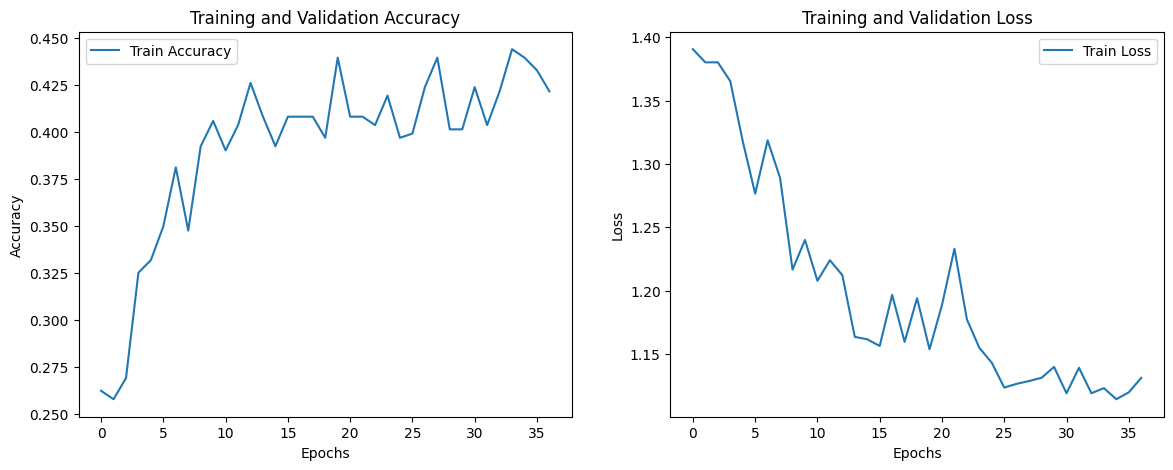

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

res = model.predict(X_test)


y_pred = np.argmax(res, axis=1)
y_true = np.argmax(y_test, axis=1)


test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


def plot_history(history):
    
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)